# Weak Subjectivity, Attestations, Rewards & Penalties (Notebook 2)
**Topics**: weak subjectivity checkpoints, attestation structure & aggregation, reward math, inactivity leak.

---
## Weak Subjectivity (WS)
- PoS relies on **historical votes**, so long‑range forks are a concern.
- **WS checkpoints**: recent state roots that nodes trust to sync from; blocks prior to WS are treated as immutable.
- Practical: get a recent checkpoint from multiple sources (e.g., explorers, peers) and sync forward objectively.


## Attestations
Every validator **attests** once per **epoch**. An attestation includes:
- `aggregation_bits` (which validators participated)
- `data = {slot, index, beacon_block_root, source, target}`
- `signature` (BLS aggregate signature)
The votes cover **source** (last justified), **target** (current epoch checkpoint), and **head** (fork choice).

In [1]:
# Simple attestation aggregation demo (toy, no BLS)
from dataclasses import dataclass
from typing import List
import random

@dataclass
class AttestationData:
    slot: int
    index: int           # committee index
    beacon_block_root: str
    source_root: str
    target_root: str

@dataclass
class Attestation:
    aggregation_bits: List[int]  # 0/1 per committee member
    data: AttestationData
    signature: str               # placeholder string, in reality BLS

def make_committee(size=32, seed=0):
    rng = random.Random(seed)
    return list(range(size))

def aggregate(attestations: List[Attestation]):
    # Combine bitlists (OR) and pretend-signature concatenation (placeholder)
    bits = [0]*len(attestations[0].aggregation_bits)
    for a in attestations:
        bits = [int(b or a.aggregation_bits[i]) for i,b in enumerate(bits)]
    sig = "agg(" + "+".join(a.signature for a in attestations) + ")"
    return bits, sig

committee = make_committee(16, seed=7)
# Two sub-sets attest
A = Attestation([1 if i<10 else 0 for i in range(16)],
                AttestationData(123, 0, "root_D", "src_X", "tgt_Y"),
                "sigA")
B = Attestation([1 if 5<=i<16 else 0 for i in range(16)],
                AttestationData(123, 0, "root_D", "src_X", "tgt_Y"),
                "sigB")
bits, sig = aggregate([A,B])
print("Aggregated bits:", bits)
print("Effective participants:", sum(bits), "/ 16")
print("Aggregated signature (placeholder):", sig)

Aggregated bits: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Effective participants: 16 / 16
Aggregated signature (placeholder): agg(sigA+sigB)


## Rewards & Penalties math (didactic)
Let’s implement the `base_reward` and show how inclusion delay affects rewards.
**Not production**—parameters are fixed per current public docs; consult specs for updates.

In [2]:
import math

BASE_REWARD_FACTOR = 64
BASE_REWARDS_PER_EPOCH = 4

def base_reward(effective_balance, total_active_balance):
    # effective_balance, total_active_balance in ETH (toy)
    return effective_balance * (BASE_REWARD_FACTOR / (BASE_REWARDS_PER_EPOCH * math.sqrt(total_active_balance)))

def attestation_reward(base, timely_source=True, timely_target=True, timely_head=True, inclusion_delay=1, in_sync_committee=False, was_proposer=False):
    # weights from docs
    weights = {
        'source': 14, 'target': 26, 'head': 14, 'sync': 2, 'proposer': 8
    }
    total = 0
    if timely_source: total += weights['source']
    if timely_target: total += weights['target']
    if timely_head:   total += weights['head']
    # inclusion delay reward scales as 1/delay times base
    inclusion_bonus = base * (1/max(1, inclusion_delay))
    # proposer/sync are rare per epoch; simulated via flags
    if in_sync_committee: total += weights['sync']
    if was_proposer: total += weights['proposer']
    # Normalize by sum-of-64 and add inclusion bonus
    return base * (total/64.0) + inclusion_bonus

eb = 32.0
total_active = 1_000_000.0  # toy
b = base_reward(eb, total_active)
for d in [1,2,4,8]:
    r = attestation_reward(b, inclusion_delay=d, was_proposer=False, in_sync_committee=False)
    print(f"Inclusion delay {d}: reward ~ {r:.6f} ETH units per epoch (toy)")

Inclusion delay 1: reward ~ 0.944000 ETH units per epoch (toy)
Inclusion delay 2: reward ~ 0.688000 ETH units per epoch (toy)
Inclusion delay 4: reward ~ 0.560000 ETH units per epoch (toy)
Inclusion delay 8: reward ~ 0.496000 ETH units per epoch (toy)


### Penalties & slashing (qualitative)
- Missing source/target incurs equal **penalties** (mirror the reward not received).
- **No penalty** for missing head vote or for failing to propose in a slot.
- **Slashing** events (double propose, double vote, surround vote) trigger immediate burn + 36‑day forced exit with a correlation penalty.
- **Inactivity leak** drains balances when finality stalls to restore >2/3 supermajority.

## Visualizing epoch/slot timing

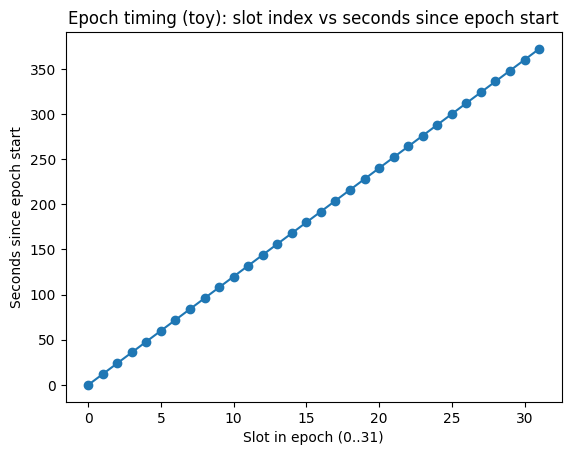

In [3]:
import matplotlib.pyplot as plt

slots = list(range(0, 32))
times = [s*12 for s in slots]
plt.figure()
plt.plot(slots, times, marker='o')
plt.title("Epoch timing (toy): slot index vs seconds since epoch start")
plt.xlabel("Slot in epoch (0..31)")
plt.ylabel("Seconds since epoch start")
plt.show()